# **Tarea 2: Segmentación**

El objetivo de esta tarea es conocer mejor a nuestra base de clientes clasificándolos en 7 u 8 grupos de clientes similares con el fin de orientar la actividad comercial de la empresa. Además también se pide poder identificar y saber cómo son los clientes que pertenecen a cada uno de estos grupos en un dashboard.

Este es un problema de Machine Learning no supervisado concretamente de asociación (o *clustering*). 

El resultado puede observarse en: [[link]].

**Solución:** Se observó que 7/8 clusters es el número idóneo y que cada unos de los clusters se identifican según los productos que compran, su país de procedencia, edad y salario. 

## **Planteamiento y solución del problema**

Para la resolución del problema se dispone de 3 datasets distintos (que se unen con las claves: *pk_cid* y *pk_partition*):
- commercial_activity_df [[1]]
- products_df [[2]]
- sociodemographic_df [[3]]


(* Antes de trabajar con los datasets, se deben limpiar y preparar individualmente)

El primer paso es unir los 3 datasets con el fin de poseer la mayor cantidad de datos de cada uno de los usuarios. Posteriormente se hará una selección de los atributos (datos relevantes de los usuarios). Nótese que algunos algoritmos que emplearemos tienen la restricción de que tan sólo trabajan con variables numéricas por lo que si se desea utilizar variables como País, éste deberá ser codificado. 

Existen 3 grandes métodos para afrontar este problema:
- KMeans
- Hierarchical clustering
- DBSCAN

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [65]:
from cleaning_data import clean_commercial_activity

my_path = '/Users/carlosperezricardo/Documents/DataScience/EasyMoney'
#my_path = '.'

commercial_activity_all = pd.read_csv(my_path+'/data/commercial_activity_df.csv', index_col=0)
partitions = commercial_activity_all['pk_partition'].unique()
partitions = sorted(partitions)

commercial_activity_df = clean_commercial_activity(commercial_activity_all, partitions)

# Liberamos espacio en la memoria
del commercial_activity_all

sociodemographic_df = pd.read_csv(my_path+'/data/sociodemographic_clean.csv', index_col=0)

from cleaning_data import clean_products

products_all = pd.read_csv(my_path+'/data/products_df.csv', index_col=0)
partitions = products_all['pk_partition'].unique()
partitions = sorted(partitions)

products_df = clean_products(products_all, partitions)

del products_all

comm_prod_socio = pd.merge(commercial_activity_df, products_df, on=['pk_cid','pk_partition'], how='outer')
comm_prod_socio = pd.merge(comm_prod_socio, sociodemographic_df, on=['pk_cid','pk_partition'], how='outer')

comm_prod_socio.head(5)

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,...,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary
0,657826,2019-05-28,2015-05-24,013,1.0,02 - PARTICULARES,False,False,False,False,...,False,False,False,True,ES,25.0,H,44,N,54493.38
1,657817,2019-05-28,2019-05-12,Sin Asignar,0.0,Sin Asignar,False,False,False,False,...,False,False,False,False,ES,8.0,V,32,N,20000.00
2,657986,2019-05-28,2016-02-18,KAF,1.0,02 - PARTICULARES,False,False,False,False,...,True,True,False,False,ES,41.0,H,39,N,100993.17
3,657905,2019-05-28,2017-02-07,KAT,1.0,01 - TOP,False,False,False,False,...,False,False,False,True,ES,28.0,H,85,N,154059.09
4,657336,2019-05-28,2019-03-28,KAT,1.0,02 - PARTICULARES,False,False,False,False,...,False,False,False,True,ES,28.0,V,38,N,88585.50


## **K-means**

K-means (o K-medias) es un método de agrupamiento, que tiene como objetivo la partición de un conjunto de n observaciones en k grupos en el que cada observación pertenece al grupo cuyo valor medio es más cercano. [[2]] 
https://es.wikipedia.org/wiki/K-medias

Uno de los requisitos para utilizar el algoritmo K-means es que las variables deben ser numéricas, por lo que si se desea emplear las variables: *gender*, *entry_channel*, *country_id* o *deceased* (que corresponden a variables categóricas) se deben pasar a variables numéricas. 

### **Atributos a seleccionar y preparación de los datos**
 
Los atributos a utilizar pueden clasificarse de la siguiente manera:

 - **Productos financieros**
 
 Se trata de variables lógicas (True/False ó 1/0 si el cliente es propietario de ese producto).
    - (X) short_term_deposit (bool) 
    - (X) loans (bool) 
    - (X) mortgage (bool)
    - (X) funds (bool)   
    - (X) securities (bool)
    - (X) long_term_deposit (bool)
    - (X) em_account_pp (bool)
    - (X) credit_card (bool)
    - (X) payroll (bool)
    - (X) pension_plan (bool)
    - (X) payroll_account (bool)
    - (X) 17 : emc_account (bool)
    - (X) 18 : debit_card (bool)   
    - (X) 19 : em_account_p (bool)
    - (X) 20 : em_acount (bool)

- **Captación del cliente**
    - entry_date (object) 
    - (X) entry_channel (category) 
    - (X) active_customer (float64) 

- **Información sociodemográfica del cliente**
    - (X) country_id () 

    Se debe hacer un one-hot encoding en esta variable para ser utilizado. En total existen 41 países diferentes en total. Como se observó en EDA del dataset *sociodemographic_df*, España es el país con más cuentas con gran diferencia. Dada la larga lista de países se opta por codificar los países en función de su continente, siendo estos: Eutopa (EU), Norte América (NA), Sud américa(SA), Asia (AS), África (AF) y España (ES). Se decide colocar España fuera de Europa dada la importancia que tiene en el dataset.

  - (X) gender (bool). 

    Se pasa a boolean, dado que se encuentra como H:Hembra, V:Varón. 
   
   - (X) age (integer) 
    
    Se normaliza con una normalización min-max.

    $$ x_i = \frac{x - min }{min - max}   $$

   - (X) deceased (bool) 

    Se pasa a boolean, dado que se encuentra como N:No, S:Si.

   - (X) salary (float64)

    Se normaliza para mediante la normalización z-score:

    $$x_i = \frac{x - \mu }{\sigma}$$
    donde $\mu $ es la media y $\sigma$ es la desviación estándar. 

In [14]:
!ls -lh

total 3000
-rw-r--r--  1 carlosperezricardo  staff   119K Feb 16 13:08 02.ipynb
drwxr-xr-x  4 carlosperezricardo  staff   128B Feb 16 12:45 __pycache__
-rw-r--r--  1 carlosperezricardo  staff   2.1K Feb 14 14:17 cleaning_data.py
-rw-r--r--@ 1 carlosperezricardo  staff   336K Feb 14 12:01 eda_commercial_activity.ipynb
-rw-r--r--@ 1 carlosperezricardo  staff    20K Feb 16 08:36 eda_commercial_activity_sin_output.ipynb
-rw-r--r--@ 1 carlosperezricardo  staff   180K Feb 16 12:39 eda_products.ipynb
-rw-r--r--  1 carlosperezricardo  staff   828K Feb 16 12:14 eda_sociodemographic.ipynb
-rw-r--r--  1 carlosperezricardo  staff   705B Feb 16 12:40 globally.py


In [66]:
paises_code = {'ES': ['ES','España'], 'GB':['EU','Gran Bretaña'], 'US':['NA','Estados Unidos'], 'FR':['EU','Francia'], 'CH':['EU','Suiza'], 'DE':['EU','Alemania'], 'BE':['EU','Bélgica'], 'BR':['SA','Brasil'], 'VE':['SA','Venezuela'], 'MX':['SA','Mexico'], 'AR':['SA','Argentina'], 'IE':['EU','Irlanda'], 'PL':['EU','Polonia'], 'IT':['EU','Italia'], 'AT':['EU','Austria'], 'SE':['EU','Suecia'], 'CL':['SA','Chile'], 'MA':['AF','Marruecos'], 'CO':['SA','Colombia'], 'DZ':['AF','Argelia'], 'SN':['AF','Senegal'], 'ET':['AF','Etiopia'], 'RU':['EU','Rusia'], 'GA':['AF','Gambia'], 'SA':['AS','Arabia Saudita'], 'MR':['AF','Mautirania'], 'HU':['EU','Hungria'], 'JM':['SA','Jamaica'], 'CM':['AF','Camerun'], 'CI':['AF','Costa de Marfil'], 'RO':['EU','Rumania'], 'PE':['SA','Perú'], 'DO':['SA','República Dominacana'], 'QA':['AS','Qatar'], 'PT':['EU','Portugal'], 'LU':['EU','Luxembburgo'], 'DJ':['AF','Yibuti'], 'GT':['SA','Guatemala'], 'CN':['AS','China'], 'NO':['EU','Noruega'], 'CA':['NA','Canada']}

# https://laendercode.net/es/2-letter-code/br

pais_continente = {}
for key, val in paises_code.items():
    pais_continente[key] = val[0]

continente = {'ES':0, 'EU':1, 'SA':2, 'NA':3, 'AS':4, 'AF':5}

comm_prod_socio['continente'] = comm_prod_socio['country_id'].replace(pais_continente)
comm_prod_socio['cont_id'] = comm_prod_socio['continente'].replace(continente)

comm_prod_socio.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,...,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,continente,cont_id
0,657826,2019-05-28,2015-05-24,013,1.0,02 - PARTICULARES,False,False,False,False,...,False,True,ES,25.0,H,44,N,54493.38,ES,0
1,657817,2019-05-28,2019-05-12,Sin Asignar,0.0,Sin Asignar,False,False,False,False,...,False,False,ES,8.0,V,32,N,20000.00,ES,0
2,657986,2019-05-28,2016-02-18,KAF,1.0,02 - PARTICULARES,False,False,False,False,...,False,False,ES,41.0,H,39,N,100993.17,ES,0
3,657905,2019-05-28,2017-02-07,KAT,1.0,01 - TOP,False,False,False,False,...,False,True,ES,28.0,H,85,N,154059.09,ES,0
4,657336,2019-05-28,2019-03-28,KAT,1.0,02 - PARTICULARES,False,False,False,False,...,False,True,ES,28.0,V,38,N,88585.50,ES,0


In [67]:
comm_prod_socio[['is_AS','is_ES','is_EU','is_NA','is_SA']] =  pd.get_dummies(comm_prod_socio['continente'], prefix='is', drop_first=True)
comm_prod_socio[['is_AS','is_ES','is_EU','is_NA','is_SA']] = comm_prod_socio[['is_AS','is_ES','is_EU','is_NA','is_SA']].astype(bool)
comm_prod_socio.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,...,age,deceased,salary,continente,cont_id,is_AS,is_ES,is_EU,is_NA,is_SA
0,657826,2019-05-28,2015-05-24,013,1.0,02 - PARTICULARES,False,False,False,False,...,44,N,54493.38,ES,0,False,True,False,False,False
1,657817,2019-05-28,2019-05-12,Sin Asignar,0.0,Sin Asignar,False,False,False,False,...,32,N,20000.00,ES,0,False,True,False,False,False
2,657986,2019-05-28,2016-02-18,KAF,1.0,02 - PARTICULARES,False,False,False,False,...,39,N,100993.17,ES,0,False,True,False,False,False
3,657905,2019-05-28,2017-02-07,KAT,1.0,01 - TOP,False,False,False,False,...,85,N,154059.09,ES,0,False,True,False,False,False
4,657336,2019-05-28,2019-03-28,KAT,1.0,02 - PARTICULARES,False,False,False,False,...,38,N,88585.50,ES,0,False,True,False,False,False


In [68]:
# Gender 
genero = {'H':0, 'V':1}
comm_prod_socio['gender_id'] = comm_prod_socio['gender'].replace(genero)
comm_prod_socio['gender_id'] = comm_prod_socio['gender_id'].astype(bool)

In [69]:
fallecido = {'N':0, 'S':1}
comm_prod_socio['deceased_id'] = comm_prod_socio['deceased'].replace(fallecido)
comm_prod_socio['deceased_id'] = comm_prod_socio['deceased_id'].astype(bool) 
comm_prod_socio['deceased_id'].head()

0    False
1    False
2    False
3    False
4    False
Name: deceased_id, dtype: bool

In [70]:
mean_salary = np.mean(comm_prod_socio['salary'])
std_salary = np.std(comm_prod_socio['salary'])

zscore = lambda x: (x - x.mean()  ) / x.std()
min_max = lambda x: (x - x.min()  ) / (x.max()-x.min())

comm_prod_socio['salary_norm'] = comm_prod_socio['salary'].transform(zscore)
comm_prod_socio['age_norm'] = comm_prod_socio['age'].transform(min_max)

comm_prod_socio.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,...,cont_id,is_AS,is_ES,is_EU,is_NA,is_SA,gender_id,deceased_id,salary_norm,age_norm
0,657826,2019-05-28,2015-05-24,013,1.0,02 - PARTICULARES,False,False,False,False,...,0,False,True,False,False,False,False,False,-0.308441,0.407767
1,657817,2019-05-28,2019-05-12,Sin Asignar,0.0,Sin Asignar,False,False,False,False,...,0,False,True,False,False,False,True,False,-0.511817,0.291262
2,657986,2019-05-28,2016-02-18,KAF,1.0,02 - PARTICULARES,False,False,False,False,...,0,False,True,False,False,False,False,False,-0.034274,0.359223
3,657905,2019-05-28,2017-02-07,KAT,1.0,01 - TOP,False,False,False,False,...,0,False,True,False,False,False,False,False,0.278608,0.805825
4,657336,2019-05-28,2019-03-28,KAT,1.0,02 - PARTICULARES,False,False,False,False,...,0,False,True,False,False,False,True,False,-0.107430,0.349515


In [71]:
df_kmeans = comm_prod_socio[['active_customer', 'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll', 'pension_plan', 'payroll_account', 'emc_account', 'debit_card', 'em_account_p', 'em_acount', 'age_norm','salary_norm', 'is_AS','is_ES','is_EU','is_NA','is_SA', 'gender_id', 'deceased_id']]
df_kmeans.head()

,active_customer,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,...,em_acount,age_norm,salary_norm,is_AS,is_ES,is_EU,is_NA,is_SA,gender_id,deceased_id
0,1.0,False,False,False,False,False,False,False,False,False,...,True,0.407767,-0.308441,False,True,False,False,False,False,False
1,0.0,False,False,False,False,False,False,False,False,False,...,False,0.291262,-0.511817,False,True,False,False,False,True,False
2,1.0,False,False,False,False,False,False,False,True,True,...,False,0.359223,-0.034274,False,True,False,False,False,False,False
3,1.0,False,False,False,False,False,True,False,False,False,...,True,0.805825,0.278608,False,True,False,False,False,False,False
4,1.0,False,False,False,False,False,False,False,False,False,...,True,0.349515,-0.107430,False,True,False,False,False,True,False


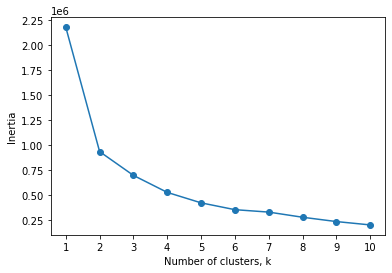

In [139]:
ks = range(1, 11)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(df_kmeans)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [144]:
from sklearn.metrics import silhouette_samples,silhouette_score

#https://medium.com/@cmukesh8688/silhouette-analysis-in-k-means-clustering-cefa9a7ad111

fig, ax = plt.subplots()

silhouette_vals = silhouette_samples(df_kmeans,y_pred)
    #silhouette_vals
# silhouette plot
y_ticks = []
y_lower = y_upper = 0
for i,cluster in enumerate(np.unique(y_predict)):
    cluster_silhouette_vals = silhouette_vals[y_predict ==cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
   
    ax.barh(range(y_lower,y_upper),
    cluster_silhouette_vals,height =1);
    ax.text(-0.03,(y_lower+y_upper)/2,str(i+1))
    y_lower += len(cluster_silhouette_vals)
       
    # Get the average silhouette score 
    avg_score = np.mean(silhouette_vals)
    ax.axvline(avg_score,linestyle ='--',linewidth =2,color = 'green')
    ax.set_yticks([])
    ax.set_xlim([-0.1, 1])
    ax.set_xlabel('Silhouette coefficient values')
    ax.set_ylabel('Cluster labels')
    ax.set_title('Silhouette plot for the various clusters');
    
    plt.tight_layout()
    plt.suptitle(f' Silhouette analysis using k = {k}',fontsize=16,fontweight = 'semibold')
    #plt.savefig(f'Silhouette_analysis_{k}.jpg')

KeyboardInterrupt: 

In [73]:
from sklearn.cluster import KMeans
k = 7
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(df_kmeans)

In [85]:
df_kmeans['cluster'] = y_pred
comm_prod_socio['cluster'] = y_pred
comm_prod_socio.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,...,is_AS,is_ES,is_EU,is_NA,is_SA,gender_id,deceased_id,salary_norm,age_norm,cluster
0,657826,2019-05-28,2015-05-24,013,1.0,02 - PARTICULARES,False,False,False,False,...,False,True,False,False,False,False,False,-0.308441,0.407767,3
1,657817,2019-05-28,2019-05-12,Sin Asignar,0.0,Sin Asignar,False,False,False,False,...,False,True,False,False,False,True,False,-0.511817,0.291262,4
2,657986,2019-05-28,2016-02-18,KAF,1.0,02 - PARTICULARES,False,False,False,False,...,False,True,False,False,False,False,False,-0.034274,0.359223,1
3,657905,2019-05-28,2017-02-07,KAT,1.0,01 - TOP,False,False,False,False,...,False,True,False,False,False,False,False,0.278608,0.805825,3
4,657336,2019-05-28,2019-03-28,KAT,1.0,02 - PARTICULARES,False,False,False,False,...,False,True,False,False,False,True,False,-0.107430,0.349515,3


In [ ]:
#sns.scatterplot(x='age', y='salary', hue='cluster', data=df_kmeans)
#plt.xlabel('Age')
#plt.ylabel('Estimated Salary')
#plt.show()

In [10]:
kmeans.cluster_centers_

array([[ 3.85861162e-01,  2.70775963e-06,  6.22784714e-05,
         3.52008751e-05,  2.36387415e-03,  3.50384096e-03,
         1.17435535e-02,  0.00000000e+00,  9.79396657e-03,
         3.61133901e-02,  3.82335659e-02,  5.80272888e-02,
         5.17263322e-02,  9.73466663e-02,  2.70775963e-06,
         6.78358773e-01,  3.03084951e+01,  8.06808428e+04],
       [ 2.50000000e-01,  8.47032947e-22,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.20417043e-18,  0.00000000e+00,  2.77777778e-02,
         2.77777778e-02,  2.77777778e-02,  2.77777778e-02,
         2.77777778e-02,  5.55555556e-02,  8.47032947e-22,
         5.83333333e-01,  3.28333333e+01,  1.04317904e+07],
       [ 5.71428571e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  4.33680869e-19,  0.00000000e+00,
         1.73472348e-18,  0.00000000e+00,  1.73472348e-18,
         6.93889390e-18,  0.00000000e+00,  6.93889390e-18,
         2.85714286e-01,  1.42857143e-01,  0.00000000e

In [137]:
kmeans.inertia_

300417.41510597663

In [123]:
clusters = []

for x in range(7):
    clusters.append(comm_prod_socio[ comm_prod_socio['cluster']==x])

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,...,is_AS,is_ES,is_EU,is_NA,is_SA,gender_id,deceased_id,salary_norm,age_norm,cluster
5,657147,2019-05-28,2017-06-09,KAT,0.0,02 - PARTICULARES,False,False,False,False,...,False,True,False,False,False,False,False,-0.011346,0.582524,0
9,655419,2019-05-28,2016-05-20,KFC,0.0,02 - PARTICULARES,False,False,False,False,...,False,True,False,False,False,False,False,0.297533,0.504854,0
12,656942,2019-05-28,2017-10-26,KAT,0.0,02 - PARTICULARES,False,False,False,False,...,False,True,False,False,False,False,False,-0.194695,0.611650,0
22,662772,2019-05-28,2018-01-07,KHK,0.0,02 - PARTICULARES,False,False,False,False,...,False,True,False,False,False,False,False,0.106046,0.533981,0
23,662366,2019-05-28,2019-02-01,KFC,0.0,02 - PARTICULARES,False,False,False,False,...,False,True,False,False,False,False,False,-0.107430,0.679612,0


In [135]:
total_products = comm_prod_socio[["short_term_deposit", "loans", "mortgage", "funds", "securities", "long_term_deposit", "em_account_pp", "credit_card", "payroll_account", "emc_account", "debit_card", "em_account_p", "em_acount", "payroll", "pension_plan"]].sum(axis=0)

In [129]:
def desc (vec, product, totals):
    x = sum(vec)
    y = len(vec)
    prop = x/y*100
    prop_total = x/totals[product]*100

    if prop < 1:
        if x == 0:
            print('  - Ninguno de este grupo ha solicitado el producto {}'.format(product))
        else:
            print('  - {} de {} ha solicitado el producto {} (lo que equivale al {:.1f} % del total)'.format(x, y, product, prop_total))
    else:
        print('  - El {:.2f} % de este grupo solicita el producto {} (lo que equivale al {:.1f} % del total) '.format(prop, product, prop_total))

In [130]:
var_bools = ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll', 'pension_plan', 'payroll_account', 'emc_account', 'debit_card', 'em_account_p', 'em_acount', ]

for x in var_bools:
    desc(cluster_4[x],x, total_products)

  - 2 de 143113 ha solicitado el producto short_term_deposit (lo que equivale al 100.0 % del total)
  - 17 de 143113 ha solicitado el producto loans (lo que equivale al 56.7 % del total)
  - 6 de 143113 ha solicitado el producto mortgage (lo que equivale al 26.1 % del total)
  - 1041 de 143113 ha solicitado el producto funds (lo que equivale al 79.2 % del total)
  - 1325 de 143113 ha solicitado el producto securities (lo que equivale al 74.1 % del total)
  - El 3.78 % de este grupo solicita el producto long_term_deposit (lo que equivale al 88.2 % del total) 
  - Ninguno de este grupo ha solicitado el producto em_account_pp
  - El 1.42 % de este grupo solicita el producto credit_card (lo que equivale al 42.4 % del total) 
  - 284 de 143113 ha solicitado el producto payroll (lo que equivale al 1.7 % del total)
  - 311 de 143113 ha solicitado el producto pension_plan (lo que equivale al 1.8 % del total)
  - 296 de 143113 ha solicitado el producto payroll_account (lo que equivale al 1.1 % 

In [136]:
for i, cluster in zip(range(7),clusters):
    print('Cluster {} ({} clientes)'.format(i, cluster.shape[0]))

    x = sum(cluster['active_customer'])
    y = len(cluster['active_customer'])
    prop = x/y*100
    print('  - El {:2f} % de clientes en este segmento es un usuario activo'.format(prop))
    for x in var_bools:
        desc(cluster[x],x, total_products)
    
    print('\n')

Cluster 0 (142759 clientes)
  - El 0.000000 % de clientes en este segmento es un usuario activo
  - Ninguno de este grupo ha solicitado el producto short_term_deposit
  - Ninguno de este grupo ha solicitado el producto loans
  - Ninguno de este grupo ha solicitado el producto mortgage
  - Ninguno de este grupo ha solicitado el producto funds
  - Ninguno de este grupo ha solicitado el producto securities
  - Ninguno de este grupo ha solicitado el producto long_term_deposit
  - Ninguno de este grupo ha solicitado el producto em_account_pp
  - 7 de 142759 ha solicitado el producto credit_card (lo que equivale al 0.1 % del total)
  - 5 de 142759 ha solicitado el producto payroll (lo que equivale al 0.0 % del total)
  - 6 de 142759 ha solicitado el producto pension_plan (lo que equivale al 0.0 % del total)
  - 356 de 142759 ha solicitado el producto payroll_account (lo que equivale al 1.3 % del total)
  - 1130 de 142759 ha solicitado el producto emc_account (lo que equivale al 4.6 % del tot

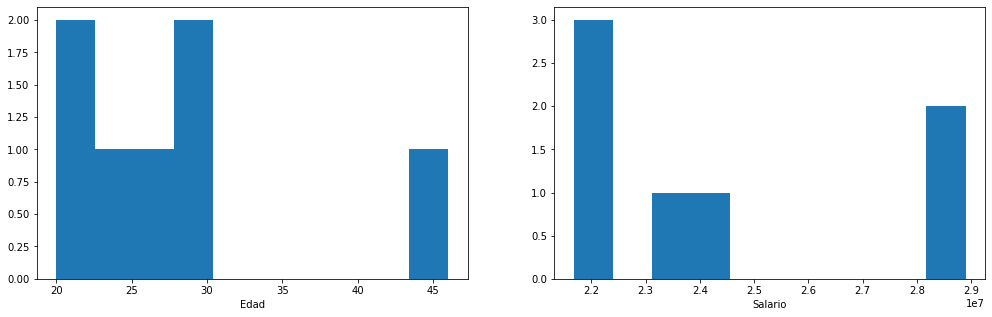

In [103]:
var_numeric = ['age','salary']

fig, ax = plt.subplots(1,2,figsize=[17,5])

ax[0].hist(cluster_3['age'],bins=10)
ax[0].set_xlabel('Edad')
ax[1].hist(cluster_3['salary'],bins=10)
ax[1].set_xlabel('Salario')
plt.show()


In [22]:
var_numeric = ['age','salary']

fig, ax = plt.subplots(figsize=[17,2])

ax.boxplot(cluster_4[var_numeric], vert=False)
plt.show()

KeyboardInterrupt: 

In [37]:
sum(cluster_7['pension_plan'])/len(cluster_7['pension_plan'])*100

4.464651558609386

In [1]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

ax1.text(0.00, 0.73, f'AAA', fontsize=40, color='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, 'orders registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'BBB', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.00, 0.31, 'orders registered in 2018\nbetween January and August', fontsize=10, ha='center')
#signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'JEJEJ%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# https://www.kaggle.com/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp

NameError: name 'plt' is not defined

In [28]:
for x in cluster_7.columns:
    if 

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.